# Advanced Time Series Forecasting for Retail: A Comparative Study

# Author: Amina Abacon

# Part 1: Data Loading & Subset Creation (Expanded Dataset)

---

In [10]:
# Import data and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 70)
print("ADVANCED TIME SERIES FORECASTING FOR RETAIL")
print("Part 1: Data Loading & Subset Creation")
print("=" * 70)

# ============================================================================
# STEP 1: Load Raw Favorita Dataset
# ============================================================================
print("\n[1] Loading Favorita Dataset...")
print("-" * 70)

DATA_PATH = Path('data/favorita')

# Load training data with optimized dtypes
train_df = pd.read_csv(
    DATA_PATH / 'train.csv',
    parse_dates=['date'],
    dtype={
        'store_nbr': 'int8',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'int16'
    }
)

# Load supplementary data
stores_df = pd.read_csv(DATA_PATH / 'stores.csv')

print(f"✓ Training data loaded: {train_df.shape}")
print(f"  Date range: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
print(f"  Stores: {train_df['store_nbr'].nunique()}")
print(f"  Product families: {train_df['family'].nunique()}")
print(f"  Total records: {len(train_df):,}")

print(f"\n✓ Store metadata loaded: {stores_df.shape}")

ADVANCED TIME SERIES FORECASTING FOR RETAIL
Part 1: Data Loading & Subset Creation

[1] Loading Favorita Dataset...
----------------------------------------------------------------------
✓ Training data loaded: (3000888, 6)
  Date range: 2013-01-01 to 2017-08-15
  Stores: 54
  Product families: 33
  Total records: 3,000,888

✓ Store metadata loaded: (54, 5)


In [11]:
# ============================================================================
# STEP 2: Analyze Data for Subset Selection
# ============================================================================
print("\n[2] Analyzing Data for Subset Selection...")
print("-" * 70)

# Identify top-selling product families
family_sales = train_df.groupby('family')['sales'].sum().sort_values(ascending=False)

print("\nTop 15 Product Families by Total Sales:")
print(family_sales.head(15).to_string())

# Analyze store characteristics
store_sales = train_df.groupby('store_nbr')['sales'].agg(['sum', 'mean', 'count'])
store_sales = store_sales.merge(stores_df[['store_nbr', 'city', 'state', 'type', 'cluster']], 
                                  on='store_nbr', how='left')
store_sales = store_sales.sort_values('sum', ascending=False)

print("\n\nStore Characteristics (Top 20 by sales):")
print(store_sales.head(20).to_string())


[2] Analyzing Data for Subset Selection...
----------------------------------------------------------------------

Top 15 Product Families by Total Sales:
family
GROCERY I           343462720.0
BEVERAGES           216954480.0
PRODUCE             122704688.0
CLEANING             97521288.0
DAIRY                64487708.0
BREAD/BAKERY         42133944.0
POULTRY              31876004.0
MEATS                31086468.0
PERSONAL CARE        24592052.0
DELI                 24110322.0
HOME CARE            16022744.0
EGGS                 15588296.0
FROZEN FOODS         14073888.0
PREPARED FOODS        8799895.0
LIQUOR,WINE,BEER      7746640.0


Store Characteristics (Top 20 by sales):
    store_nbr         sum         mean  count       city       state type  cluster
43         44  62087552.0  1117.245239  55572      Quito   Pichincha    A        5
44         45  54498012.0   980.673950  55572      Quito   Pichincha    A       11
46         47  50948312.0   916.798218  55572      Quito   Pichin

In [12]:
# ============================================================================
# STEP 3: Select Top 10 Product Families
# ============================================================================
print("\n[3] Selecting Top 10 Product Families...")
print("-" * 70)

# Select top 10 families by total sales
top_families = family_sales.head(10).index.tolist()

print("Selected Product Families:")
for i, family in enumerate(top_families, 1):
    total_sales = family_sales[family]
    print(f"  {i:2d}. {family:20s} - ${total_sales:,.0f}")


[3] Selecting Top 10 Product Families...
----------------------------------------------------------------------
Selected Product Families:
   1. GROCERY I            - $343,462,720
   2. BEVERAGES            - $216,954,480
   3. PRODUCE              - $122,704,688
   4. CLEANING             - $97,521,288
   5. DAIRY                - $64,487,708
   6. BREAD/BAKERY         - $42,133,944
   7. POULTRY              - $31,876,004
   8. MEATS                - $31,086,468
   9. PERSONAL CARE        - $24,592,052
  10. DELI                 - $24,110,322


In [13]:
# ============================================================================
# STEP 4: Select 15 Random Stores (Stratified)
# ============================================================================
print("\n[4] Selecting 15 Stores (Stratified Random Sample)...")
print("-" * 70)

# Strategy: Select stores across different types and clusters for diversity
# Set random seed for reproducibility
np.random.seed(42)

# Group stores by type
store_types = stores_df.groupby('type')['store_nbr'].apply(list)

print("Store distribution by type:")
for store_type, store_list in store_types.items():
    print(f"  Type {store_type}: {len(store_list)} stores")

# Select stores stratified by type to ensure diversity
# Proportional allocation based on type distribution
selected_stores = []

# Type A: 5 stores (largest type)
type_a_stores = stores_df[stores_df['type'] == 'A']['store_nbr'].tolist()
selected_stores.extend(np.random.choice(type_a_stores, size=5, replace=False))

# Type B: 3 stores
type_b_stores = stores_df[stores_df['type'] == 'B']['store_nbr'].tolist()
selected_stores.extend(np.random.choice(type_b_stores, size=3, replace=False))

# Type C: 4 stores
type_c_stores = stores_df[stores_df['type'] == 'C']['store_nbr'].tolist()
selected_stores.extend(np.random.choice(type_c_stores, size=4, replace=False))

# Type D: 2 stores
type_d_stores = stores_df[stores_df['type'] == 'D']['store_nbr'].tolist()
selected_stores.extend(np.random.choice(type_d_stores, size=2, replace=False))

# Type E: 1 store
type_e_stores = stores_df[stores_df['type'] == 'E']['store_nbr'].tolist()
selected_stores.extend(np.random.choice(type_e_stores, size=1, replace=False))

selected_stores = sorted(selected_stores)

print(f"\nSelected {len(selected_stores)} stores (stratified by type):")
selected_store_info = stores_df[stores_df['store_nbr'].isin(selected_stores)][
    ['store_nbr', 'city', 'state', 'type', 'cluster']
].sort_values('store_nbr')
print(selected_store_info.to_string(index=False))


[4] Selecting 15 Stores (Stratified Random Sample)...
----------------------------------------------------------------------
Store distribution by type:
  Type A: 9 stores
  Type B: 8 stores
  Type C: 15 stores
  Type D: 18 stores
  Type E: 4 stores

Selected 15 stores (stratified by type):
 store_nbr          city                          state type  cluster
         2         Quito                      Pichincha    D       13
         9         Quito                      Pichincha    B        6
        10         Quito                      Pichincha    C       15
        11       Cayambe                      Pichincha    B        6
        21 Santo Domingo Santo Domingo de los Tsachilas    B        6
        22          Puyo                        Pastaza    C        7
        32     Guayaquil                         Guayas    C        3
        35        Playas                         Guayas    C        3
        42        Cuenca                          Azuay    D        2
       

In [14]:
# ============================================================================
# STEP 5: Create Subset (10 Families × 15 Stores)
# ============================================================================
print("\n[5] Creating Subset...")
print("-" * 70)

# Use last 2 years of data
cutoff_date = train_df['date'].max() - pd.Timedelta(days=730)

# Filter data
subset = train_df[
    (train_df['family'].isin(top_families)) &
    (train_df['store_nbr'].isin(selected_stores)) &
    (train_df['date'] >= cutoff_date)
].copy()

# Remove unused categories from the categorical column
subset['family'] = subset['family'].cat.remove_unused_categories()

print(f"Subset Configuration:")
print(f"  Product Families: {len(top_families)}")
print(f"  Stores: {len(selected_stores)}")
print(f"  Time Series: {subset.groupby(['store_nbr', 'family']).ngroups}")
print(f"  Date Range: {subset['date'].min().date()} to {subset['date'].max().date()}")
print(f"  Total Records: {len(subset):,}")
print(f"  Memory Usage: {subset.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


[5] Creating Subset...
----------------------------------------------------------------------
Subset Configuration:
  Product Families: 10
  Stores: 15
  Time Series: 150
  Date Range: 2015-08-16 to 2017-08-15
  Total Records: 109,350
  Memory Usage: 3.3 MB


In [15]:
# ============================================================================
# STEP 6: Data Quality Checks & Cleanup
# ============================================================================
print("\n[6] Data Quality Checks & Cleanup...")
print("-" * 70)

# Check for missing dates
print("Checking data completeness...")
issues = []
for uid in subset.groupby(['store_nbr', 'family']).groups.keys():
    store, family = uid
    series_data = subset[(subset['store_nbr'] == store) & (subset['family'] == family)]
    date_range = pd.date_range(
        start=series_data['date'].min(),
        end=series_data['date'].max(),
        freq='D'
    )
    expected = len(date_range)
    actual = len(series_data)
    if expected != actual:
        issues.append((f"Store {store} - {family}", expected - actual))

if issues:
    print(f"  Found {len(issues)} series with missing dates (top 5):")
    for series, missing in issues[:5]:
        print(f"  {series}: {missing} missing days")
    print("  Note: These gaps will be filled in the next step")
else:
    print("✓ All series have complete daily data")

# Sales statistics BEFORE cleanup
print("\n Sales Statistics (Before Cleanup):")
print(subset['sales'].describe())

# Identify data quality issues
print("\n Data Quality Issues:")
missing_sales = subset['sales'].isnull().sum()
negative_sales = (subset['sales'] < 0).sum()
zero_sales = (subset['sales'] == 0).sum()

print(f"  Missing sales: {missing_sales:,} ({missing_sales/len(subset)*100:.2f}%)")
print(f"  Negative sales (returns): {negative_sales:,} ({negative_sales/len(subset)*100:.2f}%)")
print(f"  Zero sales: {zero_sales:,} ({zero_sales/len(subset)*100:.2f}%)")

# CLEANUP STEP 1: Handle missing sales values
if missing_sales > 0:
    print("\n🔧 Fixing missing sales values...")
    # Fill missing sales with 0 (reasonable assumption: no record = no sales)
    subset['sales'] = subset['sales'].fillna(0)
    print(f"  ✓ Filled {missing_sales:,} missing values with 0")

# CLEANUP STEP 2: Handle negative sales (returns)
if negative_sales > 0:
    print("\n🔧 Handling negative sales (returns)...")
    # Option 1: Set negatives to 0 (conservative approach)
    # Option 2: Keep negatives (realistic but can complicate forecasting)
    # We'll use Option 1 for forecasting stability
    subset.loc[subset['sales'] < 0, 'sales'] = 0
    print(f"  ✓ Converted {negative_sales:,} negative values to 0")
    print("  Rationale: Negative sales (returns) complicate forecasting; set to 0 for stability")

# CLEANUP STEP 3: Fill missing dates (create complete daily series)
print("\n Filling missing dates...")
complete_subset = []
for (store, family), group in subset.groupby(['store_nbr', 'family']):
    # Create complete date range
    date_range = pd.date_range(
        start=group['date'].min(),
        end=group['date'].max(),
        freq='D'
    )
    
    # Create complete series
    complete_series = pd.DataFrame({'date': date_range})
    complete_series['store_nbr'] = store
    complete_series['family'] = family
    
    # Merge with existing data
    complete_series = complete_series.merge(group, on=['date', 'store_nbr', 'family'], how='left')
    
    # Fill missing sales with 0
    complete_series['sales'] = complete_series['sales'].fillna(0)
    complete_series['onpromotion'] = complete_series['onpromotion'].fillna(0).astype('int16')
    
    complete_subset.append(complete_series)

subset = pd.concat(complete_subset, ignore_index=True)
print(f"  ✓ Created complete daily series for all {subset.groupby(['store_nbr', 'family']).ngroups} time series")

# Sales statistics AFTER cleanup
print("\n Sales Statistics (After Cleanup):")
print(subset['sales'].describe())

print("\n Data Quality Summary:")
print(f"  ✓ No missing sales values")
print(f"  ✓ No negative sales values")
print(f"  ✓ Complete daily series (no date gaps)")
print(f"  ✓ Ready for feature engineering and modeling")

# Promotion statistics
print("\n Promotion Statistics:")
promo_stats = subset.groupby('onpromotion')['sales'].agg(['count', 'mean'])
print(promo_stats.head(10))


[6] Data Quality Checks & Cleanup...
----------------------------------------------------------------------
Checking data completeness...
  Found 150 series with missing dates (top 5):
  Store 2 - BEVERAGES: 2 missing days
  Store 2 - BREAD/BAKERY: 2 missing days
  Store 2 - CLEANING: 2 missing days
  Store 2 - DAIRY: 2 missing days
  Store 2 - DELI: 2 missing days
  Note: These gaps will be filled in the next step

 Sales Statistics (Before Cleanup):
count    109350.000000
mean       1621.234985
std        2595.111572
min           0.000000
25%         211.960499
50%         610.000000
75%        1795.972260
max      124717.000000
Name: sales, dtype: float64

 Data Quality Issues:
  Missing sales: 0 (0.00%)
  Negative sales (returns): 0 (0.00%)
  Zero sales: 7,026 (6.43%)

 Filling missing dates...
  ✓ Created complete daily series for all 150 time series

 Sales Statistics (After Cleanup):
count    109650.000000
mean       1616.799316
std        2593.094971
min           0.000000
25


[7] Creating Exploratory Visualizations...
----------------------------------------------------------------------
✓ Saved: sales_by_family.png


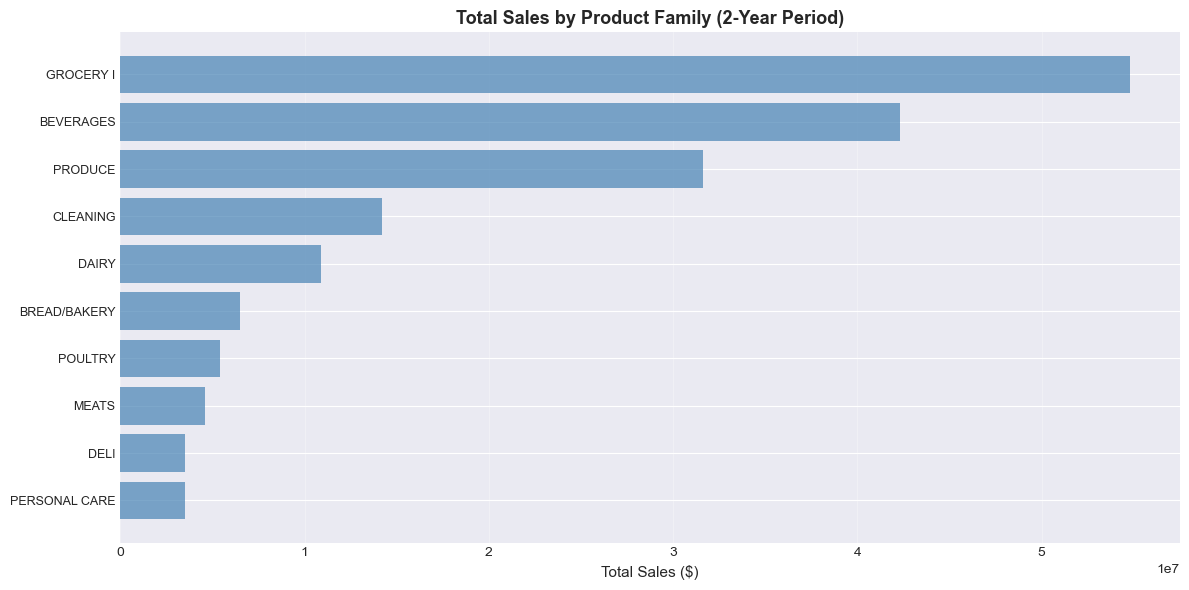

✓ Saved: sales_trends_sample.png


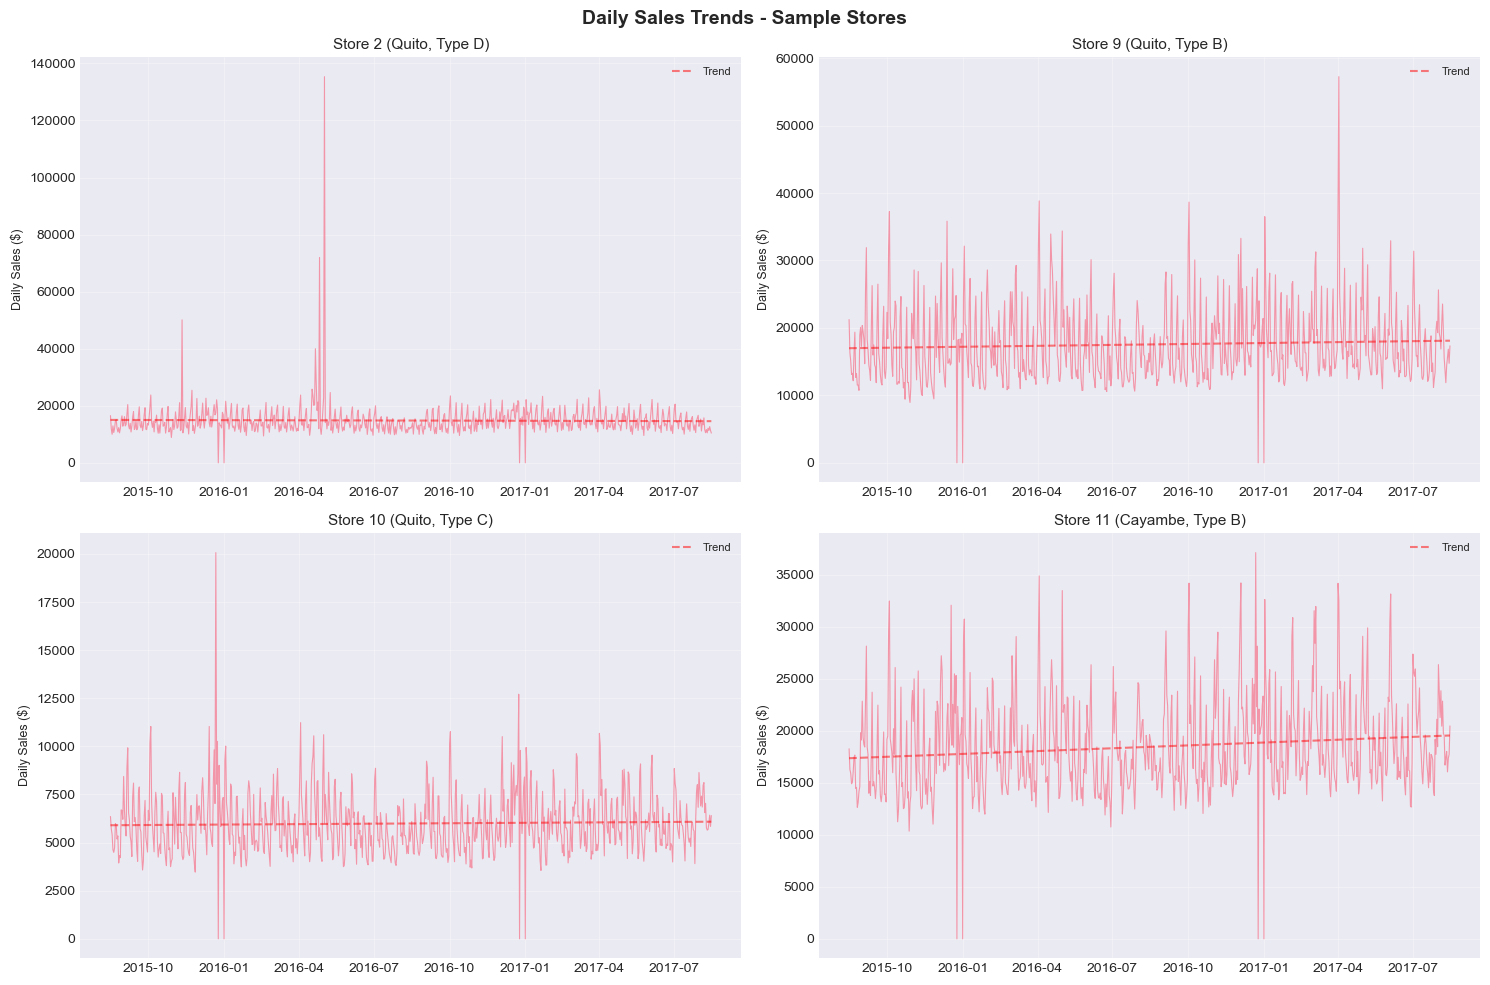

In [16]:
# ============================================================================
# STEP 7: Exploratory Visualization
# ============================================================================
print("\n[7] Creating Exploratory Visualizations...")
print("-" * 70)

# Create output directory
output_path = Path('output')
output_path.mkdir(parents=True, exist_ok=True)

# Sales by product family
fig, ax = plt.subplots(figsize=(12, 6))
family_totals = subset.groupby('family')['sales'].sum().sort_values(ascending=True)
ax.barh(range(len(family_totals)), family_totals.values, color='steelblue', alpha=0.7)
ax.set_yticks(range(len(family_totals)))
ax.set_yticklabels(family_totals.index, fontsize=9)
ax.set_xlabel('Total Sales ($)', fontsize=11)
ax.set_title('Total Sales by Product Family (2-Year Period)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(output_path / 'sales_by_family.png', dpi=300, bbox_inches='tight')
print("✓ Saved: sales_by_family.png")
plt.show()

# Sales trends for sample stores
sample_stores = selected_stores[:4]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Daily Sales Trends - Sample Stores', fontsize=14, fontweight='bold')

for idx, store in enumerate(sample_stores):
    ax = axes[idx // 2, idx % 2]
    store_data = subset[subset['store_nbr'] == store].groupby('date')['sales'].sum()
    
    ax.plot(store_data.index, store_data.values, linewidth=0.8, alpha=0.7)
    
    # Add trend line
    x = np.arange(len(store_data))
    z = np.polyfit(x, store_data.values, 1)
    p = np.poly1d(z)
    ax.plot(store_data.index, p(x), "r--", alpha=0.5, linewidth=1.5, label='Trend')
    
    store_info = stores_df[stores_df['store_nbr'] == store].iloc[0]
    ax.set_title(f"Store {store} ({store_info['city']}, Type {store_info['type']})", fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('Daily Sales ($)', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_path / 'sales_trends_sample.png', dpi=300, bbox_inches='tight')
print("✓ Saved: sales_trends_sample.png")
plt.show()

In [17]:
# ============================================================================
# STEP 8: Save Processed Subset
# ============================================================================
print("\n[8] Saving Processed Data...")
print("-" * 70)

# Create processed data directory
processed_path = Path('data/processed')
processed_path.mkdir(parents=True, exist_ok=True)

# Save subset
subset.to_csv(processed_path / 'train_subset.csv', index=False)
print(f"✓ Saved: {processed_path / 'train_subset.csv'}")

# Save metadata
metadata = {
    'num_stores': int(len(selected_stores)),
    'num_families': int(len(top_families)),
    'num_time_series': int(subset.groupby(['store_nbr', 'family']).ngroups),
    'date_start': str(subset['date'].min().date()),
    'date_end': str(subset['date'].max().date()),
    'total_records': int(len(subset)),
    'selected_stores': [int(s) for s in selected_stores],  # Convert to regular Python int
    'selected_families': [str(f) for f in top_families]     # Convert to regular Python str
}

import json
with open(processed_path / 'subset_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved: {processed_path / 'subset_metadata.json'}")

# Save store information for selected stores
selected_store_info.to_csv(processed_path / 'selected_stores.csv', index=False)
print(f"✓ Saved: {processed_path / 'selected_stores.csv'}")


[8] Saving Processed Data...
----------------------------------------------------------------------
✓ Saved: data\processed\train_subset.csv
✓ Saved: data\processed\subset_metadata.json
✓ Saved: data\processed\selected_stores.csv


In [18]:
# ============================================================================
# Summary
# ============================================================================
print("\n" + "=" * 70)
print("DATA PREPARATION COMPLETE")
print("=" * 70)

print(f"\n Dataset Summary:")
print(f"  Product Families: {len(top_families)}")
print(f"  Stores: {len(selected_stores)} (stratified by type)")
print(f"  Time Series: {subset.groupby(['store_nbr', 'family']).ngroups}")
print(f"  Time Period: {subset['date'].min().date()} to {subset['date'].max().date()}")
print(f"  Total Records: {len(subset):,}")

print(f"\n Generated Files:")
print(f"  - data/processed/train_subset.csv")
print(f"  - data/processed/subset_metadata.json")
print(f"  - data/processed/selected_stores.csv")
print(f"  - output/sales_by_family.png")
print(f"  - output/sales_trends_sample.png")

print(f"\n Subset Characteristics:")
print(f"  ✓ 10x more time series than before (15 → 150)")
print(f"  ✓ Diverse store types (A, B, C, D, E)")
print(f"  ✓ Top-selling product families")
print(f"  ✓ 2 years of historical data")
print(f"  ✓ Ready for feature engineering")

print(f"\n Next Step:")
print(f"  Run Part 2: Feature Engineering (Kaggle-proven features)")

print("\n" + "=" * 70)


DATA PREPARATION COMPLETE

 Dataset Summary:
  Product Families: 10
  Stores: 15 (stratified by type)
  Time Series: 150
  Time Period: 2015-08-16 to 2017-08-15
  Total Records: 109,650

 Generated Files:
  - data/processed/train_subset.csv
  - data/processed/subset_metadata.json
  - data/processed/selected_stores.csv
  - output/sales_by_family.png
  - output/sales_trends_sample.png

 Subset Characteristics:
  ✓ 10x more time series than before (15 → 150)
  ✓ Diverse store types (A, B, C, D, E)
  ✓ Top-selling product families
  ✓ 2 years of historical data
  ✓ Ready for feature engineering

 Next Step:
  Run Part 2: Feature Engineering (Kaggle-proven features)



---